# Signal Direction Analysis

## Packages

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from   tqdm import tqdm

import statsmodels.api as sm
from   statsmodels.regression.rolling import RollingOLS

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [4]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/TreasuryInflationPCA/root/src")
from BackgroundFuncs import BackgroundHelperFuncs

In [5]:
def get_backtest() -> pd.DataFrame: 

    df_log_pc       = BackgroundHelperFuncs().get_log_pca()
    df_log_backtest = (BackgroundHelperFuncs().get_log_backtest(df_log_pc)[
        ["date", "variable", "lag_spread", "security", "PX_bps"]].
        assign(input_var = "log"))
    
    df_pc           = BackgroundHelperFuncs().get_pca()
    df_reg_backtest = (BackgroundHelperFuncs().get_backtest(df_pc)[
        ["date", "variable", "lag_spread", "security", "PX_bps"]].
        assign(input_var = "no_log"))
    
    df_out = (pd.concat(
        [df_log_backtest, df_reg_backtest]).
        assign(security = lambda x: x.security.str.split(" ").str[0]))
    
    return df_out

df_backtest = get_backtest()

## Generic Approach

First start with the running a full sample regression and then examining the betas

In [8]:
def _get_beta(df: pd.DataFrame) -> pd.DataFrame: 

    alpha, beta = (sm.OLS(
        endog = df.PX_bps,
        exog  = sm.add_constant(df.lag_spread)).
        fit().
        params)

    return beta

def get_beta(df_backtest: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df_backtest.assign(
        group_var = lambda x: x.variable + "_" + x.security + "_" + x.input_var))
    
    df_linker = (df_tmp[
        ["group_var", "variable", "security", "input_var"]])
    
    df_out = (df_tmp.groupby(
        "group_var").
        apply(_get_beta, include_groups = False).
        to_frame(name = "beta").
        merge(right = df_linker, how = "inner", on = ["group_var"]).
        drop(columns = ["group_var"]).
        drop_duplicates())

    return df_out

df_beta = get_beta(df_backtest)

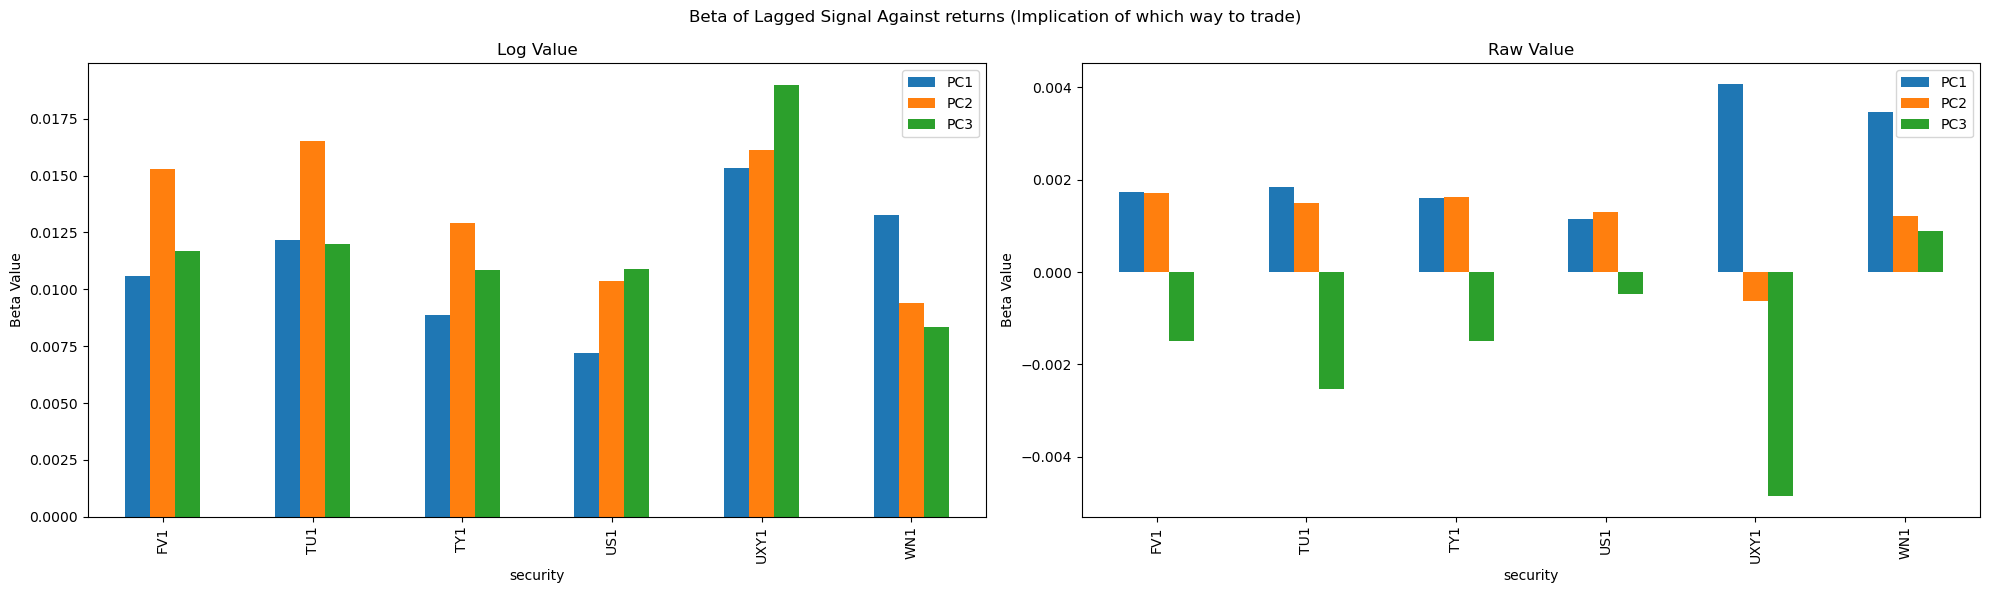

In [9]:
def plot_full_sample_regression(df_beta: pd.DataFrame) -> plt.Figure: 

    group_vars = df_beta.input_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars), figsize = (20,6))
    
    renamer = {
        "log"   : "Log Value",
        "no_log": "Raw Value"}
    
    for group_var, ax in zip(group_vars, axes.flatten()): 
        
        (df_beta.query(
            "input_var == @group_var").
            drop(columns = ["input_var"]).
            rename(columns = {"variable": ""}).
            pivot(index = "security", columns = "", values = "beta").
            plot(
                kind   = "bar",
                ax     = ax,
                ylabel = "Beta Value",
                title  = renamer[group_var]))
    
    fig.suptitle("Beta of Lagged Signal Against returns (Implication of which way to trade)")
    plt.tight_layout()

plot_full_sample_regression(df_beta)

Now trade the signal based on the sign

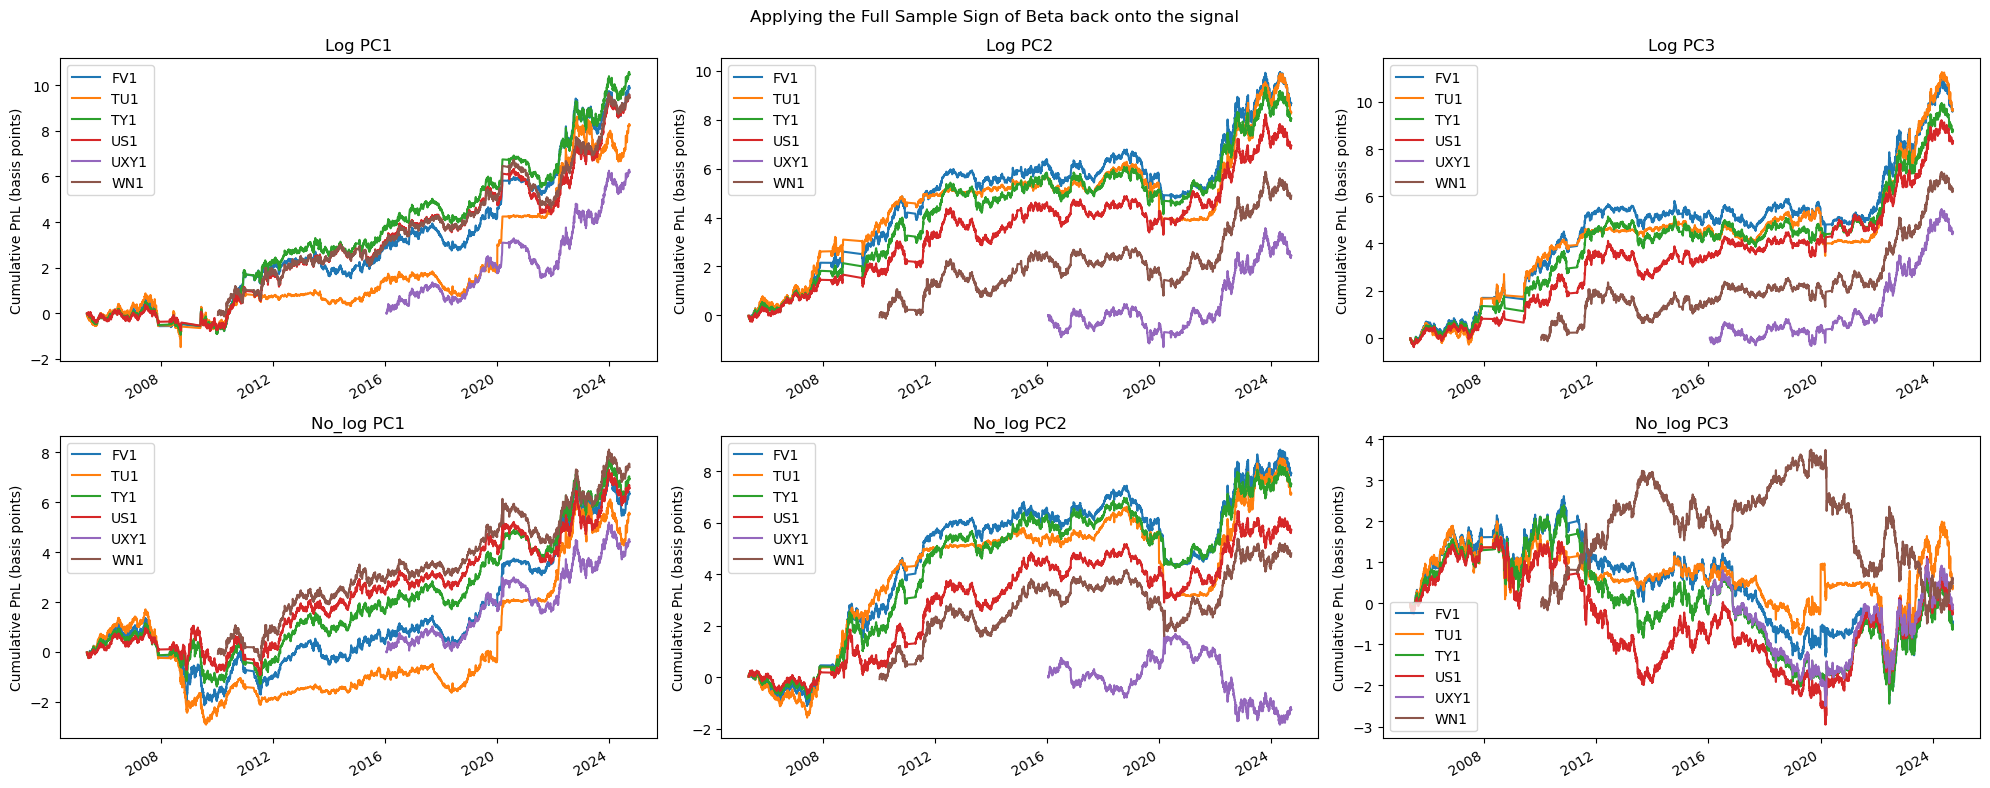

In [11]:
def plot_apply_sign(df_backtest: pd.DataFrame, df_beta: pd.DataFrame) -> plt.Figure: 

    df_tmp = (df_backtest.merge(
        right = df_beta, how = "inner", on = ["variable" , "security", "input_var"]).
        assign(
            signal_rtn = lambda x: np.sign(x.beta) * np.sign(x.lag_spread) * x.PX_bps,
            group_var  = lambda x: x.input_var.str.capitalize() + " " + x.variable))
    
    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,8))
    
    for group_var, ax in zip(group_vars, axes.flatten()):
    
        (df_tmp.query(
            "group_var == @group_var")
            [["date", "security", "signal_rtn"]].
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            cumsum().
            plot(
                ax     = ax,
                ylabel = "Cumulative PnL (basis points)",
                xlabel = "",
                title  = group_var))

    fig.suptitle("Applying the Full Sample Sign of Beta back onto the signal")
    plt.tight_layout()

plot_apply_sign(df_backtest, df_beta)

Now run a rolling regression and analyze the beta. 

In [13]:
def _get_rolling_beta(df: pd.DataFrame, window: int) -> pd.DataFrame: 

    df_out = (RollingOLS(
        endog  = df.PX_bps,
        exog   = sm.add_constant(df.lag_spread),
        window = window).
        fit().
        params.
        assign(date = lambda x: df.date))

    return df_out


def get_rolling_beta(df_backtest: pd.DataFrame, window: int = 100) -> pd.DataFrame: 

    df_tmp = (df_backtest.assign(
        group_var = lambda x: x.variable + "_" + x.security + "_" + x.input_var))
    
    df_roll_beta = (df_tmp.groupby(
        "group_var").
        apply(_get_rolling_beta, window, include_groups = False).
        reset_index().
        drop(columns = ["level_1"]).
        assign(
            pc        = lambda x: x.group_var.str.split("_").str[0],
            security  = lambda x: x.group_var.str.split("_").str[1],
            input_var = lambda x: x.group_var.str.split("_").str[2]).
        drop(columns = ["group_var"]).
        dropna())

    return df_roll_beta

df_roll_beta = get_rolling_beta(df_backtest)

In [14]:
def _get_sample_beta(df: pd.DataFrame, sample_size: float) -> pd.DataFrame: 

    df_tmp = (df.sample(
        frac = sample_size))

    alpha, beta = (sm.OLS(
        endog = df_tmp.PX_bps,
        exog  = sm.add_constant(df_tmp.lag_spread)).
        fit().
        params)

    return beta


def _sample_beta(df_backtest: pd.DataFrame, sample_size: float) -> pd.DataFrame: 

    df_tmp = (df_backtest.assign(
        group_var = lambda x: x.variable + "_" + x.security + "_" + x.input_var))
    
    df_linker = (df_tmp[
        ["group_var", "variable", "security", "input_var"]])
    
    df_out = (df_tmp.groupby(
        "group_var").
        apply(_get_sample_beta, sample_size, include_groups = False).
        to_frame(name = "beta").
        merge(right = df_linker, how = "inner", on = ["group_var"]).
        drop(columns = ["group_var"]))

    return df_out

def sample_beta(df_backtest: pd.DataFrame, sample_size: float = 0.3, sims: int = 1_000) -> pd.DataFrame: 

    df_out = (pd.concat([
        _sample_beta(df_backtest, sample_size).assign(sim = i + 1) 
        for i in tqdm(range(sims), desc = "Simulations")]).
        drop_duplicates())

    return df_out

df_sample_beta = sample_beta(df_backtest)

Simulations: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:16<00:00, 13.07it/s]


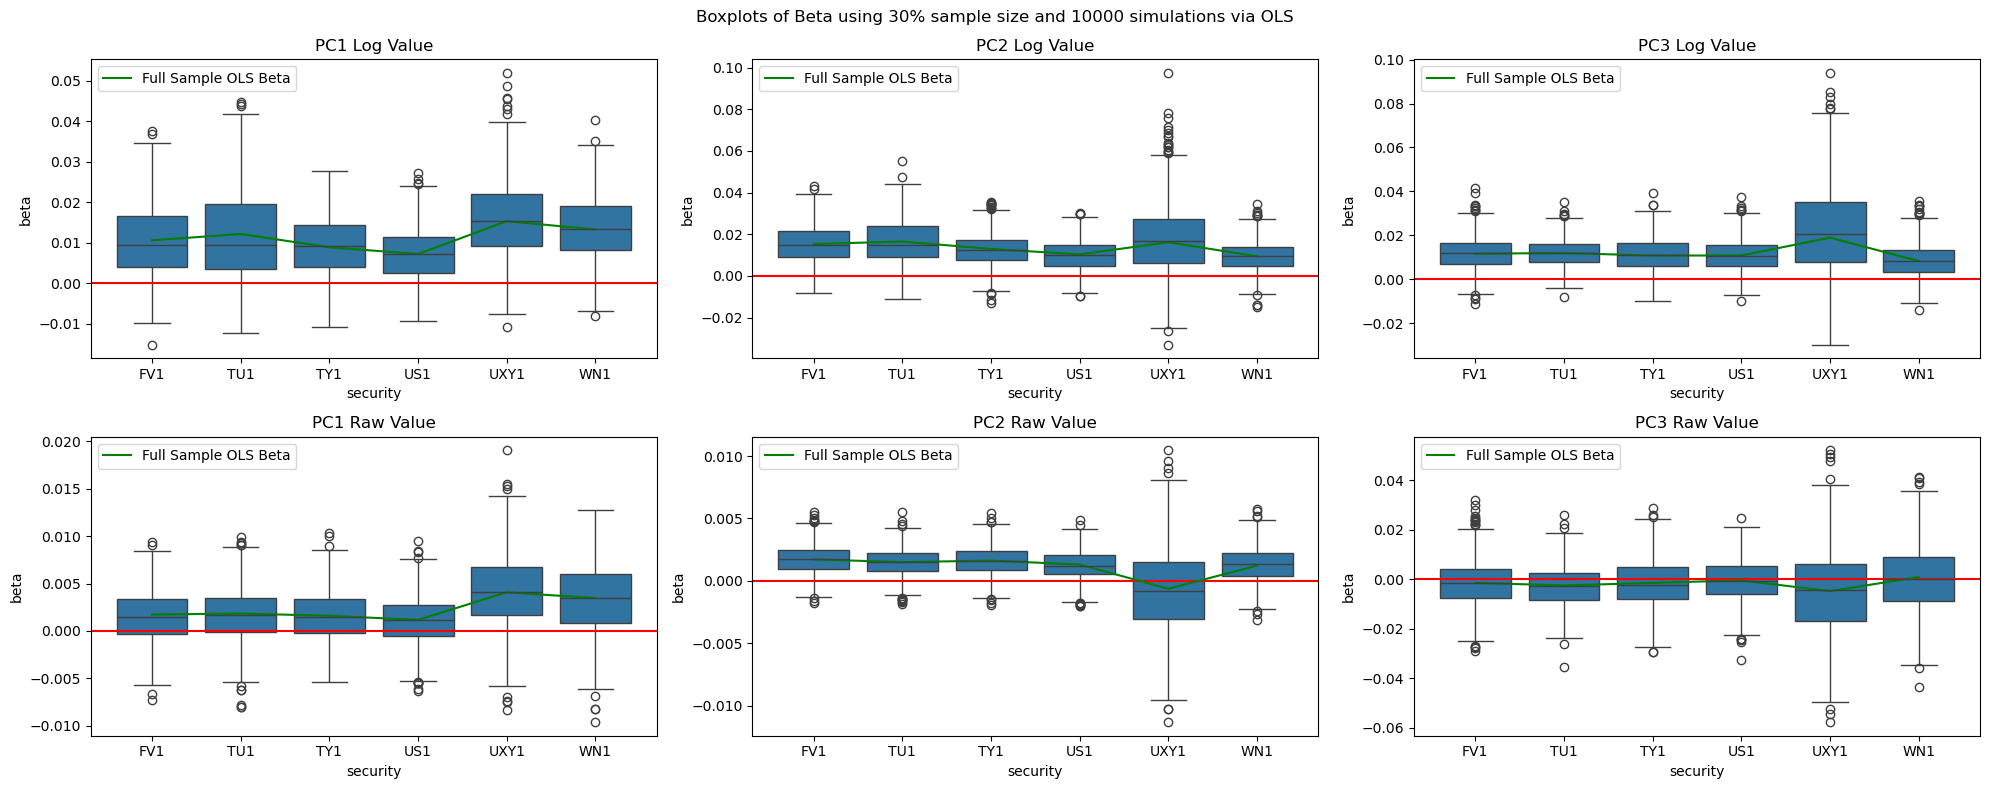

In [26]:
def plot_sample_beta(df_sample_beta: pd.DataFrame, df_beta: pd.DataFrame, sample_size: float, sims: int) -> plt.Figure: 

    df_tmp = (df_sample_beta.assign(
        input_var = lambda x: np.where(x.input_var == "log", "Log Value", "Raw Value"),
        group_var = lambda x: x.variable + " " + x.input_var))
    
    df_beta_tmp = (df_beta.assign(
        input_var = lambda x: np.where(x.input_var == "log", "Log Value", "Raw Value"),
        group_var = lambda x: x.variable + " " + x.input_var))
    
    group_vars = df_tmp.sort_values(["input_var", "variable"]).group_var.drop_duplicates().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,8))
    
    for group_var, ax in zip(group_vars, axes.flatten()): 
    
        df_plot = (df_tmp.query(
            "group_var == @group_var"))
    
        sns.boxplot(x = "security", y = "beta", data = df_plot, ax = ax)
        ax.set_title(group_var)
        ax.axhline(y = 0, color = "red")
    
        df_beta_plot = (df_beta_tmp.query(
            "group_var == @group_var").
            set_index("security")
            [["beta"]])
    
        ax.plot(df_beta_plot.index, df_beta_plot.beta, color = "green", label = "Full Sample OLS Beta")
        ax.legend()

    fig.suptitle("Boxplots of Beta using {}% sample size and {} simulations via OLS".format(
        sample_size,
        sims))
    plt.tight_layout()

plot_sample_beta(df_sample_beta, df_beta, 30, 10_000)